In [241]:
# dropando colunas ficou bom
# nao precisando dropar ficou melhor
# randomsearch ajudou
# DROP: 'SEMANA_DE_NAO_PAGAMENTO', 'SEMANA_PAGAMENTO', 'FERIADO'
# ANTES: 749 -> 590

In [242]:
# imports
import pandas as pd
import numpy as np
from dateutil import parser

In [243]:
# configs
import warnings
warnings.filterwarnings("ignore")

In [244]:
# read csvs & build dataframe
df = pd.read_csv('./datasets/2_dados_correlacionados.csv', ',')
pd.set_option('display.max_rows', 50)

In [245]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

import mpld3
import matplotlib.style as style
import matplotlib.pyplot as plt
mpld3.enable_notebook()

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# featured engineering
X = df.drop(columns=['DATA', 'VENDAS', 'SEMANA_DE_NAO_PAGAMENTO', 'SEMANA_PAGAMENTO', 'FERIADO'])
y = df.drop(columns=['DATA', 'FDS', 'DS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'DATA_NAO_FESTIVA', 'FERIADO', 'NAO_FERIADO', 'SEMANA_PAGAMENTO', 'SEMANA_DE_NAO_PAGAMENTO', 'BAIXA_TEMPORADA', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE'])

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# feature scaling
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

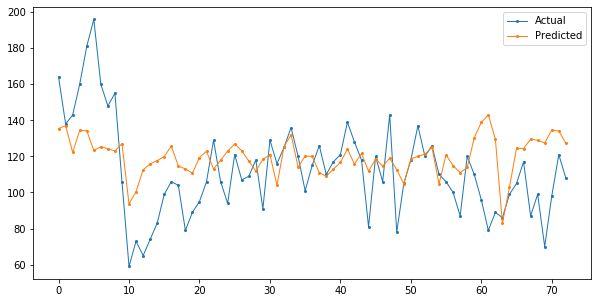

MSE: 650.0732604383284


Weight,Feature
0.1992 ± 0.0301,VESPERA_DATA_FESTIVA
0.0513 ± 0.0217,POS_DATA_FESTIVA
0.0463 ± 0.0303,UMIDADE
0.0339 ± 0.0515,PRECIPITACAO
0.0317 ± 0.0287,ALTA_TEMPORADA
0.0305 ± 0.0495,TEMPERATURA
0.0299 ± 0.0368,BAIXA_TEMPORADA
0.0070 ± 0.0060,FDS
0.0069 ± 0.0053,DS
0 ± 0.0000,QTD_CONCORRENTES


In [246]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

tree2 = AdaBoostRegressor(DecisionTreeRegressor(ccp_alpha=0.1, criterion='mse', max_depth=600,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=23,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'), n_estimators=2000, random_state=0, loss='square')
tree2.fit(X_train, y_train)
y_pred = tree2.predict(X_test)
scores = cross_val_score(tree2, X_test, y_test, cv=10)
df1 = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

print(f'MSE: {metrics.mean_squared_error(y_test, y_pred)}')

perm = PermutationImportance(tree2, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.values.tolist())

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.1,
                                                       criterion='friedman_mse',
                                                       max_depth=200,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=23,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
      

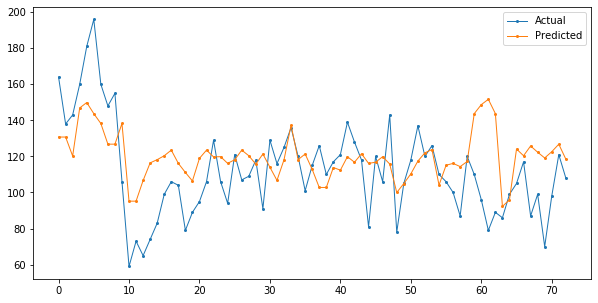

RMSE: 604.9027618494517


In [247]:
# random saearch
from scipy.stats import randint as sp_randint

params = {
    'loss': ['exponential'],
    'learning_rate': [0.1],
    'n_estimators': [60],
    'random_state': [0]
}
dt = DecisionTreeRegressor(ccp_alpha=0.1, 
                           criterion='friedman_mse', 
                           max_depth=200, 
                           max_features=None, 
                           max_leaf_nodes=None, 
                           min_impurity_decrease=0.0, 
                           min_impurity_split=None, 
                           min_samples_leaf=1, 
                           min_samples_split=23, 
                           min_weight_fraction_leaf=0.0, 
                           presort='deprecated', 
                           random_state=None, 
                           splitter='best')
ada = AdaBoostRegressor(dt)
search_obj = RandomizedSearchCV(ada, param_distributions=params)
fit_obj = search_obj.fit(X_train, y_train)
print(fit_obj.best_estimator_)

# modeling
b_model = fit_obj.best_estimator_
b_model.fit(X_train, y_train)
b_y_pred = b_model.predict(X_test)
b_y_pred
df2 = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': b_y_pred.flatten()})
df2.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

# printing first metrics
print(f'RMSE: {metrics.mean_squared_error(y_test, b_y_pred, squared=True)}')